In [105]:
import numpy as numpy
import pandas as pd
import xgboost as xgb
import hyperopt as hpt
from preprocessing.country_and_airports_codes import compute_lon_lat,group_and_rename_countries, group_and_rename_airports, group_and_rename_aircraft_types
from preprocessing.encoding import one_hot_encoding,string_to_value_count, string_to_int_hashing
from preprocessing.local_time import add_localtime_to_train_and_test

In [106]:
space = {'max_depth': hpt.hp.quniform('max_depth', 2, 10, 1),
         'gamma': hpt.hp.uniform('gamma', 0.1, 5),
         'reg_alpha': hpt.hp.uniform('reg_alpha', 0.1, 5),
         'reg_lambda': hpt.hp.uniform('reg_lambda', 0.1, 5),
         'learning_rate': hpt.hp.uniform('learning_rate', 0.01, 0.2),
         'n_estimators': hpt.hp.quniform('n_estimators', 100, 1000, 1),
         'min_child_weight': hpt.hp.quniform('min_child_weight', 1, 10, 1),
         'subsample': hpt.hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hpt.hp.uniform('colsample_bytree', 0.5, 1),
         'seed': 0}

In [107]:
train_df = pd.read_csv("./data/preprocessed_challenge_set.csv", index_col=0)
test_df = pd.read_csv("./data/preprocessed_submission_set.csv", index_col=0)

# encoding

columns_to_ohe = [] # A changer
one_hot_encoding(train_df, test_df, columns_to_ohe)

columns_to_hash = ['callsign','country_code_ades', 'country_code_adep', 'adep', 'ades', 'airline','aircraft_type','wtc'] # A changer
string_to_int_hashing(train_df, test_df, columns_to_hash)

columns_to_vc = [] # A changer
string_to_value_count(train_df, test_df, columns_to_vc)

# drop unusefull column:
to_drop = ['flight_id','date','name_adep','name_ades','name_adep','actual_offblock_time','arrival_time','local_departure_time','local_arrival_time']
train_df = train_df.drop(columns= to_drop)
test_df = test_df.drop(columns= to_drop)



----------------------------------------------------------------------------------------------------
Columns [] sucessfully one hot encoded !
----------------------------------------------------------------------------------------------------
        flight_id        date  callsign  adep               name_adep  \
0       248753821  2022-01-01      2495    92  Istanbul Sabiha Gokcen   
1       248753822  2022-01-01      9518     1                Brussels   
2       248754498  2022-01-01      1902    50                   Miami   
3       248763650  2022-01-01      2259     1                Brussels   
4       248763651  2022-01-01     10029    89                  Zurich   
...           ...         ...       ...   ...                     ...   
158144  258068876  2022-12-31      8596    93            iGA Istanbul   
158145  258064675  2022-12-31        35    23               Amsterdam   
158146  258065436  2022-12-31      5684    58               Barcelona   
158147  258058138  2022-12-

In [108]:
X = train_df.drop(columns=['tow'])
y = train_df['tow']

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


print("Train shape: ", X_train.shape)
print("Test shape: ", X_test.shape)


print(y_test)

display(X_train)

Train shape:  (295210, 20)
Test shape:  (73803, 20)
360642     78793.000000
362899    161373.000000
29041      59859.000000
27883      46853.000000
198546     59827.152595
              ...      
204954    220632.000000
42079      70694.000000
141949    188305.000000
158625     20944.000000
3440       57851.000000
Name: tow, Length: 73803, dtype: float64


,callsign,adep,country_code_adep,ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,local_arrival_hour,local_departure_hour,travel_day_of_week,travel_day_of_year,departure_month,lon_adep,lat_adep,lon_ades,lat_ades
217511,5530,115,11,142,20,8,1,6,137,5,921,9,6,2,229,8,-4.43306,55.87190,10.88850,45.39570
138479,9756,140,19,38,23,3,1,18,117,5,744,22,20,2,159,6,29.89130,69.72580,11.10040,60.19390
249849,10501,19,11,30,18,1,1,20,59,25,333,11,9,0,255,9,-0.46194,51.47060,-8.92482,52.70200
247970,7688,82,0,74,10,4,1,13,133,8,927,12,10,6,254,9,16.56970,48.11030,1.37312,38.87290
218954,10649,93,45,68,3,8,1,14,66,16,307,14,13,3,230,8,28.75200,41.27533,23.41144,42.69669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,9738,91,45,115,51,3,1,14,57,10,289,22,21,0,353,12,27.66430,37.25060,28.75200,41.27533
358083,4699,0,1,135,10,17,1,27,130,5,861,9,7,5,351,12,4.46028,51.18940,-1.12500,37.80300
152315,6817,67,10,29,18,3,1,20,79,19,460,11,11,6,170,6,2.55000,49.01280,-6.27007,53.42130
117952,1631,104,12,37,23,0,1,18,230,20,1544,15,12,5,141,5,24.14970,35.53170,8.08537,58.20420


In [109]:
def objective(params):
    clf = xgb.XGBRegressor(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            gamma=params['gamma'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'],
                            learning_rate=params['learning_rate'],
                            min_child_weight=params['min_child_weight'],
                            subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)
    
    eval_set = [(X_train, y_train), (X_test, y_test)]

    clf.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    y_pred = clf.predict(X_test)

    score = root_mean_squared_error(y_test, y_pred)
    print("SCORE: ", score)
    return {'loss': score, 'status': hpt.STATUS_OK}

trials = hpt.Trials()
best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=100, trials=trials)

SCORE:                                                 
3331.441016245872                                      
SCORE:                                                                          
3379.027606277691                                                               
SCORE:                                                                          
3340.0120205319336                                                              
SCORE:                                                                          
5150.145605755436                                                               
SCORE:                                                                          
6695.020926691396                                                               
SCORE:                                                                          
3497.2935508180026                                                              
SCORE:                                                                        

In [110]:
display(best)

{'colsample_bytree': 0.9362150768343058,
 'gamma': 2.022211195429398,
 'learning_rate': 0.07900609044575752,
 'max_depth': 10.0,
 'min_child_weight': 1.0,
 'n_estimators': 862.0,
 'reg_alpha': 1.6659492680583492,
 'reg_lambda': 4.4589665080717085,
 'subsample': 0.7470405034939882}

In [111]:
# train xgboost with best hyperparameters

clf = xgb.XGBRegressor(n_estimators=int(best['n_estimators']),
                        max_depth=int(best['max_depth']),
                        gamma=best['gamma'],
                        reg_alpha=best['reg_alpha'],
                        reg_lambda=best['reg_lambda'],
                        learning_rate=best['learning_rate'],
                        min_child_weight=best['min_child_weight'],
                        subsample=best['subsample'],
                        colsample_bytree=best['colsample_bytree'],
                        seed=0,
                        objective="reg:squarederror",
                        eval_metric="rmse",
                        early_stopping_rounds=10,
                        n_jobs=-1)

eval_set = [(X_train, y_train), (X_test, y_test)]

clf.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# predict on test set

y_pred = clf.predict(X_test)

score = root_mean_squared_error(y_pred, y_test)

display(y_pred)
print("SCORE: ", score)

[0]	validation_0-rmse:49106.95864	validation_1-rmse:49104.62854
[1]	validation_0-rmse:45297.67917	validation_1-rmse:45290.67325
[2]	validation_0-rmse:41788.69159	validation_1-rmse:41779.35573
[3]	validation_0-rmse:38560.29655	validation_1-rmse:38550.21535
[4]	validation_0-rmse:35584.41737	validation_1-rmse:35571.58038
[5]	validation_0-rmse:32860.94853	validation_1-rmse:32844.85486
[6]	validation_0-rmse:30341.34194	validation_1-rmse:30323.84145
[7]	validation_0-rmse:28024.32711	validation_1-rmse:28006.24784
[8]	validation_0-rmse:25893.29954	validation_1-rmse:25873.45382
[9]	validation_0-rmse:23989.96128	validation_1-rmse:23968.36459
[10]	validation_0-rmse:22181.59489	validation_1-rmse:22160.26338
[11]	validation_0-rmse:20517.84251	validation_1-rmse:20496.66305
[12]	validation_0-rmse:18988.77452	validation_1-rmse:18968.21497
[13]	validation_0-rmse:17625.24930	validation_1-rmse:17605.18034
[14]	validation_0-rmse:16332.39486	validation_1-rmse:16310.96468
[15]	validation_0-rmse:15147.60401	

array([ 77772.   , 169493.06 ,  61380.934, ..., 181230.12 ,  20792.93 ,
        54825.965], dtype=float32)

SCORE:  3148.878078026515


In [112]:
# compute the root mean squared error

print("RMSE: ", score)

RMSE:  3148.878078026515


Average relative error: 0.027491056935531357
Average absolute error: 2008.199016513261


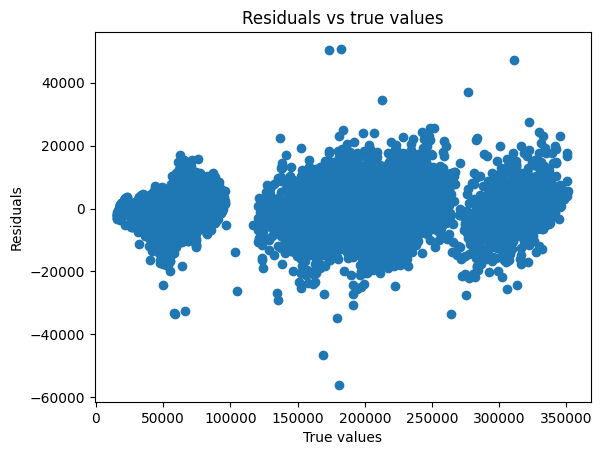

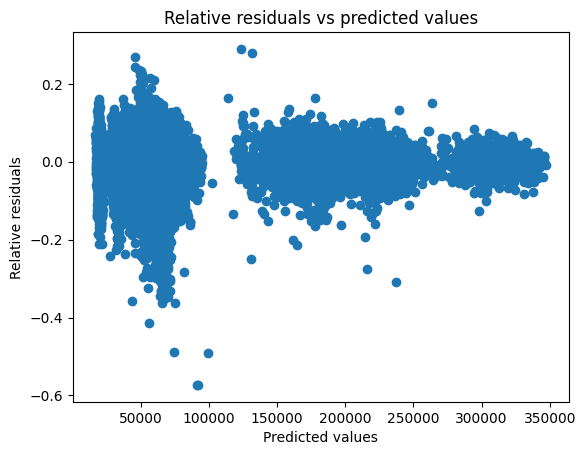

In [113]:
import matplotlib.pyplot as plt

# compute average relative error

relative_error = abs(y_test - y_pred) / y_test

average_relative_error = relative_error.mean()

print(f"Average relative error: {average_relative_error}")

# compute average absolute error

absolute_error = abs(y_test - y_pred)

average_absolute_error = absolute_error.mean()

print(f"Average absolute error: {average_absolute_error}")

# plot residuals vs true values

plt.scatter(y_test, (y_test-y_pred))

plt.xlabel("True values")

plt.ylabel("Residuals")

plt.title("Residuals vs true values")

plt.show()

# plot residuals vs predicted values

plt.scatter(y_pred, (y_test-y_pred)/y_test)

plt.xlabel("Predicted values")

plt.ylabel("Relative residuals")

plt.title("Relative residuals vs predicted values")

plt.show()



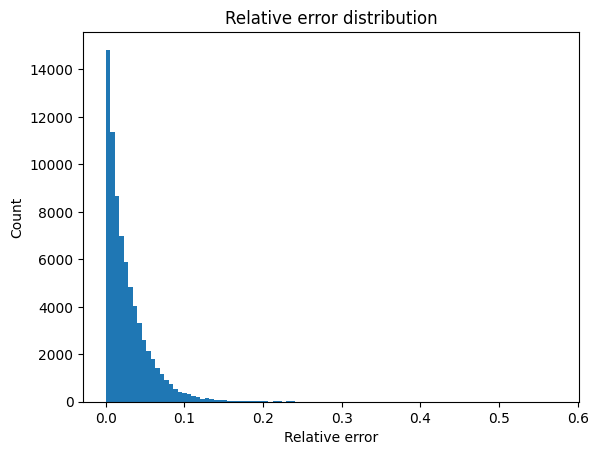

In [114]:
#plot relative error distribution

plt.hist(relative_error, bins=100)

plt.xlabel("Relative error")

plt.ylabel("Count")

plt.title("Relative error distribution")

plt.show()

# plot absolute error distribution

In [115]:
print(relative_error.mean())

0.027491056935531357


In [116]:
# same optimization on retriced set wtc = 1

x_train_wtc1 = X_train[X_train['wtc'] == 1]

y_train_wtc1 = y_train[X_train['wtc'] == 1]

x_test_wtc1 = X_test[X_test['wtc'] == 1]

y_test_wtc1 = y_test[X_test['wtc'] == 1]

space = {'max_depth': hpt.hp.quniform('max_depth', 2, 10, 1),
            'gamma': hpt.hp.uniform('gamma', 0.1, 5),
            'reg_alpha': hpt.hp.uniform('reg_alpha', 0.1, 5),
            'reg_lambda': hpt.hp.uniform('reg_lambda', 0.1, 5),
            'learning_rate': hpt.hp.uniform('learning_rate', 0.01, 0.2),
            'n_estimators': hpt.hp.quniform('n_estimators', 100, 1000, 1),
            'min_child_weight': hpt.hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hpt.hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hpt.hp.uniform('colsample_bytree', 0.5, 1),
            'seed': 0}

def objective(params):
    clf = xgb.XGBRegressor(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            gamma=params['gamma'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'],
                            learning_rate=params['learning_rate'],
                            min_child_weight=params['min_child_weight'],
                            subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)
    
    eval_set = [(x_train_wtc1, y_train_wtc1), (x_test_wtc1, y_test_wtc1)]

    clf.fit(x_train_wtc1, y_train_wtc1, eval_set=eval_set, verbose=False)
    y_pred = clf.predict(x_test_wtc1)

    score = root_mean_squared_error(y_test_wtc1, y_pred)
    print("SCORE: ", score)
    return {'loss': score, 'status': hpt.STATUS_OK}


trials = hpt.Trials()

best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=20, trials=trials)

display(best)

SCORE:                                                
2987.8427850551084                                    
SCORE:                                                                          
2807.614912180419                                                               
SCORE:                                                                          
2341.5053085779996                                                             
SCORE:                                                                          
3119.0998752159053                                                              
SCORE:                                                                          
3475.2982440795126                                                              
SCORE:                                                                          
3266.6940407946004                                                              
SCORE:                                                                          


{'colsample_bytree': 0.9865346417369687,
 'gamma': 2.311730004603916,
 'learning_rate': 0.1355408626893648,
 'max_depth': 9.0,
 'min_child_weight': 2.0,
 'n_estimators': 890.0,
 'reg_alpha': 2.7683944404030436,
 'reg_lambda': 0.10259397496527922,
 'subsample': 0.6971029355383804}

In [117]:
# train xgboost with best hyperparameters

clf_wtc1 = xgb.XGBRegressor(n_estimators=int(best['n_estimators']),
                            max_depth=int(best['max_depth']),
                            gamma=best['gamma'],
                            reg_alpha=best['reg_alpha'],
                            reg_lambda=best['reg_lambda'],
                            learning_rate=best['learning_rate'],
                            min_child_weight=best['min_child_weight'],
                            subsample=best['subsample'],
                            colsample_bytree=best['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)

eval_set = [(x_train_wtc1, y_train_wtc1), (x_test_wtc1, y_test_wtc1)]

clf_wtc1.fit(x_train_wtc1, y_train_wtc1, eval_set=eval_set, verbose=True)

# predict on test set

y_pred_wtc1 = clf_wtc1.predict(x_test_wtc1)

score = root_mean_squared_error(y_pred_wtc1, y_test_wtc1)
                       

[0]	validation_0-rmse:12244.84978	validation_1-rmse:12196.46849
[1]	validation_0-rmse:10727.65765	validation_1-rmse:10690.57796
[2]	validation_0-rmse:9431.17458	validation_1-rmse:9404.05025
[3]	validation_0-rmse:8331.20028	validation_1-rmse:8313.19291
[4]	validation_0-rmse:7398.99308	validation_1-rmse:7389.38714
[5]	validation_0-rmse:6613.95594	validation_1-rmse:6611.71810
[6]	validation_0-rmse:5951.92546	validation_1-rmse:5955.82558
[7]	validation_0-rmse:5399.08133	validation_1-rmse:5409.93233
[8]	validation_0-rmse:4939.66003	validation_1-rmse:4957.35515
[9]	validation_0-rmse:4645.71509	validation_1-rmse:4669.42042
[10]	validation_0-rmse:4316.03407	validation_1-rmse:4344.70670
[11]	validation_0-rmse:4042.40509	validation_1-rmse:4077.29570
[12]	validation_0-rmse:3816.82271	validation_1-rmse:3857.57800
[13]	validation_0-rmse:3681.24108	validation_1-rmse:3727.01013
[14]	validation_0-rmse:3512.45016	validation_1-rmse:3563.52817
[15]	validation_0-rmse:3379.99482	validation_1-rmse:3435.9463

In [118]:
# same optimization on retriced set wtc = 0

x_train_wtc0 = X_train[X_train['wtc'] == 0]

y_train_wtc0 = y_train[X_train['wtc'] == 0]

x_test_wtc0 = X_test[X_test['wtc'] == 0]

y_test_wtc0 = y_test[X_test['wtc'] == 0]

space = {'max_depth': hpt.hp.quniform('max_depth', 2, 10, 1),
            'gamma': hpt.hp.uniform('gamma', 0.1, 5),
            'reg_alpha': hpt.hp.uniform('reg_alpha', 0.1, 5),
            'reg_lambda': hpt.hp.uniform('reg_lambda', 0.1, 5),
            'learning_rate': hpt.hp.uniform('learning_rate', 0.01, 0.2),
            'n_estimators': hpt.hp.quniform('n_estimators', 100, 1000, 1),
            'min_child_weight': hpt.hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hpt.hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hpt.hp.uniform('colsample_bytree', 0.5, 1),
            'seed': 0}

def objective(params):
    clf = xgb.XGBRegressor(n_estimators=int(params['n_estimators']),
                            max_depth=int(params['max_depth']),
                            gamma=params['gamma'],
                            reg_alpha=params['reg_alpha'],
                            reg_lambda=params['reg_lambda'],
                            learning_rate=params['learning_rate'],
                            min_child_weight=params['min_child_weight'],
                            subsample=params['subsample'],
                            colsample_bytree=params['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)
    
    eval_set = [(x_train_wtc0, y_train_wtc0), (x_test_wtc0, y_test_wtc0)]

    clf.fit(x_train_wtc0, y_train_wtc0, eval_set=eval_set, verbose=False)
    y_pred = clf.predict(x_test_wtc0)

    score = root_mean_squared_error(y_test_wtc0, y_pred)
    print("SCORE: ", score)
    return {'loss': score, 'status': hpt.STATUS_OK}


trials = hpt.Trials()

best = hpt.fmin(fn=objective, space=space, algo=hpt.tpe.suggest, max_evals=100, trials=trials)

display(best)

SCORE:                                                 
6398.719368285577                                      
SCORE:                                                                          
6479.458763341954                                                               
SCORE:                                                                          
7165.310590087736                                                               
SCORE:                                                                          
7459.508321564086                                                               
SCORE:                                                                          
6421.930125190423                                                               
SCORE:                                                                          
6443.982596082197                                                               
SCORE:                                                                        

{'colsample_bytree': 0.8497066984064998,
 'gamma': 1.8567356656935454,
 'learning_rate': 0.041891010160377044,
 'max_depth': 9.0,
 'min_child_weight': 8.0,
 'n_estimators': 859.0,
 'reg_alpha': 3.709715865940738,
 'reg_lambda': 1.6089032820385571,
 'subsample': 0.8005286414941816}

In [119]:
# train xgboost with best hyperparameters

clf_wtc0 = xgb.XGBRegressor(n_estimators=int(best['n_estimators']),
                            max_depth=int(best['max_depth']),
                            gamma=best['gamma'],
                            reg_alpha=best['reg_alpha'],
                            reg_lambda=best['reg_lambda'],
                            learning_rate=best['learning_rate'],
                            min_child_weight=best['min_child_weight'],
                            subsample=best['subsample'],
                            colsample_bytree=best['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            early_stopping_rounds=10,
                            n_jobs=-1)

eval_set = [(x_train_wtc0, y_train_wtc0), (x_test_wtc0, y_test_wtc0)]

clf_wtc0.fit(x_train_wtc0, y_train_wtc0, eval_set=eval_set, verbose=True)

# predict on test set

y_pred_wtc0 = clf_wtc0.predict(x_test_wtc0)

score = root_mean_squared_error(y_pred_wtc0, y_test_wtc0)

# compute the root mean squared error

print("RMSE: ", score)

[0]	validation_0-rmse:40181.99832	validation_1-rmse:39991.01348
[1]	validation_0-rmse:38810.71866	validation_1-rmse:38627.26468
[2]	validation_0-rmse:37274.51858	validation_1-rmse:37099.57903
[3]	validation_0-rmse:35807.24411	validation_1-rmse:35638.36734
[4]	validation_0-rmse:34404.10672	validation_1-rmse:34242.70340
[5]	validation_0-rmse:33056.21079	validation_1-rmse:32900.62715
[6]	validation_0-rmse:31906.04300	validation_1-rmse:31758.88578
[7]	validation_0-rmse:30832.58202	validation_1-rmse:30693.88922
[8]	validation_0-rmse:29644.50729	validation_1-rmse:29509.45773
[9]	validation_0-rmse:28631.15547	validation_1-rmse:28509.28919
[10]	validation_0-rmse:27536.77488	validation_1-rmse:27422.31620
[11]	validation_0-rmse:26491.68513	validation_1-rmse:26383.79358
[12]	validation_0-rmse:25492.91162	validation_1-rmse:25394.06198
[13]	validation_0-rmse:24681.54919	validation_1-rmse:24591.09379
[14]	validation_0-rmse:23762.52370	validation_1-rmse:23681.47962
[15]	validation_0-rmse:22884.45057	

In [133]:
y_pred_wtc0 = clf_wtc0.predict(X_test)

y_pred_wtc1 = clf_wtc1.predict(X_test)

y_pred = clf.predict(X_test)

y_pred_aggregate = (y_pred_wtc0 * (X_test['wtc'] == 0) + y_pred_wtc1 * (X_test['wtc'] == 1) + y_pred)/2

In [135]:
# compute the root mean squared error

score = root_mean_squared_error(y_pred_aggregate, y_test)
print("RMSE: ", score)

RMSE:  1897.6949376318444


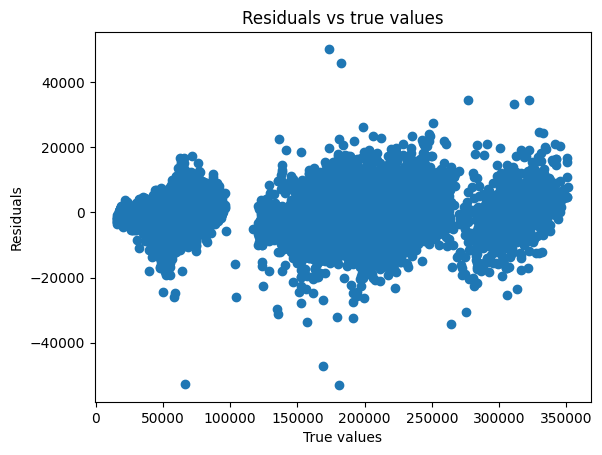

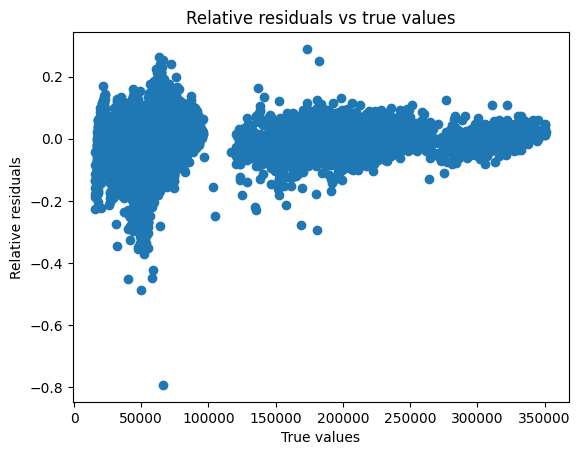

In [122]:
# plot residuals vs true values

plt.scatter(y_test, (y_test-y_pred_aggregate))

plt.xlabel("True values")

plt.ylabel("Residuals")

plt.title("Residuals vs true values")

plt.show()

# plot relative error vs true values

plt.scatter(y_test, (y_test-y_pred_aggregate)/y_test)

plt.xlabel("True values")

plt.ylabel("Relative residuals")

plt.title("Relative residuals vs true values")

plt.show()



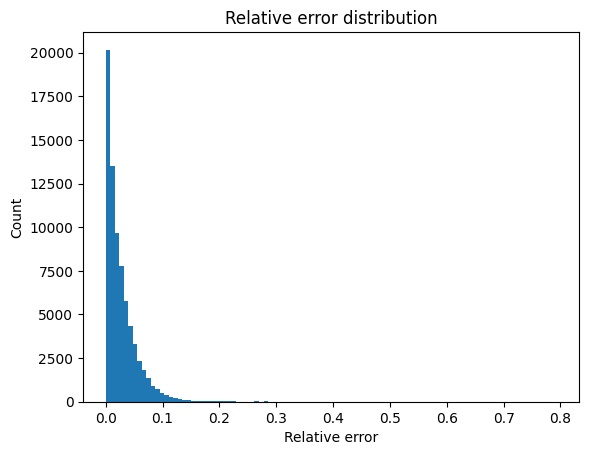

In [123]:
# plot relative error distribution

plt.hist(abs(y_test - y_pred_aggregate) / y_test, bins=100)

plt.xlabel("Relative error")

plt.ylabel("Count")

plt.title("Relative error distribution")

plt.show()



In [124]:
# print average relative error

relative_error = abs(y_test - y_pred_aggregate) / y_test

average_relative_error = relative_error.mean()

print(f"Average relative error: {average_relative_error}")

# print average absolute error

absolute_error = abs(y_test - y_pred_aggregate)

average_absolute_error = absolute_error.mean()

print(f"Average absolute error: {average_absolute_error}")

seuil = 0.05

print(f"Percentage of predictions with relative error below {seuil}: {100 * (relative_error < seuil).mean()}")

print(f"Percentage of predictions with relative error below {2*seuil}: {100 * (relative_error < 2*seuil).mean()}")

print(f"Percentage of predictions with relative error below {3*seuil}: {100 * (relative_error < 3*seuil).mean()}")

Average relative error: 0.02687618677307991
Average absolute error: 1967.23046325129
Percentage of predictions with relative error below 0.05: 84.4423668414563
Percentage of predictions with relative error below 0.1: 97.55023508529463
Percentage of predictions with relative error below 0.15000000000000002: 99.42956248390988


In [128]:
# retrain the model on all the dataset without early stopping

basic_param = {'colsample_bytree': 0.9362150768343058,
 'gamma': 2.022211195429398,
 'learning_rate': 0.07900609044575752,
 'max_depth': 10.0,
 'min_child_weight': 1.0,
 'n_estimators': 862.0,
 'reg_alpha': 1.6659492680583492,
 'reg_lambda': 4.4589665080717085,
 'subsample': 0.7470405034939882}

clf = xgb.XGBRegressor(n_estimators=int(basic_param['n_estimators']),
                            max_depth=int(basic_param['max_depth']),
                            gamma=basic_param['gamma'],
                            reg_alpha=basic_param['reg_alpha'],
                            reg_lambda=basic_param['reg_lambda'],
                            learning_rate=basic_param['learning_rate'],
                            min_child_weight=basic_param['min_child_weight'],
                            subsample=basic_param['subsample'],
                            colsample_bytree=basic_param['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            n_jobs=-1)

eval_set = [(X, y)]

clf.fit(X, y, eval_set=eval_set, verbose=False)

wtc0_param = {'colsample_bytree': 0.8497066984064998,
 'gamma': 1.8567356656935454,
 'learning_rate': 0.041891010160377044,
 'max_depth': 9.0,
 'min_child_weight': 8.0,
 'n_estimators': 859.0,
 'reg_alpha': 3.709715865940738,
 'reg_lambda': 1.6089032820385571,
 'subsample': 0.8005286414941816}


clf_wtc0 = xgb.XGBRegressor(n_estimators=int(wtc0_param['n_estimators']),
                            max_depth=int(wtc0_param['max_depth']),
                            gamma=wtc0_param['gamma'],
                            reg_alpha=wtc0_param['reg_alpha'],
                            reg_lambda=wtc0_param['reg_lambda'],
                            learning_rate=wtc0_param['learning_rate'],
                            min_child_weight=wtc0_param['min_child_weight'],
                            subsample=wtc0_param['subsample'],
                            colsample_bytree=wtc0_param['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            n_jobs=-1)

x_train_wtc0 = X[X['wtc'] == 0]

y_train_wtc0 = y[X['wtc'] == 0]

eval_set = [(x_train_wtc0, y_train_wtc0)]

clf_wtc0.fit(x_train_wtc0, y_train_wtc0, eval_set=eval_set, verbose=False)

wtc1_param = {'colsample_bytree': 0.9865346417369687,
 'gamma': 2.311730004603916,
 'learning_rate': 0.1355408626893648,
 'max_depth': 9.0,
 'min_child_weight': 2.0,
 'n_estimators': 890.0,
 'reg_alpha': 2.7683944404030436,
 'reg_lambda': 0.10259397496527922,
 'subsample': 0.6971029355383804}

clf_wtc1 = xgb.XGBRegressor(n_estimators=int(wtc1_param['n_estimators']),
                            max_depth=int(wtc1_param['max_depth']),
                            gamma=wtc1_param['gamma'],
                            reg_alpha=wtc1_param['reg_alpha'],
                            reg_lambda=wtc1_param['reg_lambda'],
                            learning_rate=wtc1_param['learning_rate'],
                            min_child_weight=wtc1_param['min_child_weight'],
                            subsample=wtc1_param['subsample'],
                            colsample_bytree=wtc1_param['colsample_bytree'],
                            seed=0,
                            objective="reg:squarederror",
                            eval_metric="rmse",
                            n_jobs=-1)

x_train_wtc1 = X[X['wtc'] == 1]

y_train_wtc1 = y[X['wtc'] == 1]

eval_set = [(x_train_wtc1, y_train_wtc1)]

clf_wtc1.fit(x_train_wtc1, y_train_wtc1, eval_set=eval_set, verbose=False)



y_pred_wtc0 = clf_wtc0.predict(test_df)

y_pred_wtc1 = clf_wtc1.predict(test_df)

y_pred = clf.predict(test_df)

y_pred_aggregate = (y_pred_wtc0 * (test_df['wtc'] == 0) + y_pred_wtc1 * (test_df['wtc'] == 1) + y_pred)/2





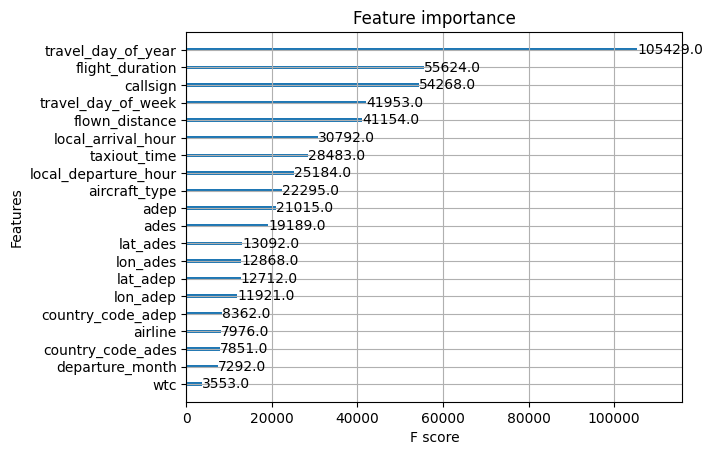

In [129]:
# plot clf model importance

import matplotlib.pyplot as plt

xgb.plot_importance(clf)

plt.show()

In [130]:
# add y_pred_aggregate to test_df

test_df['tow'] = y_pred_aggregate

display(test_df)

,callsign,adep,country_code_adep,ades,country_code_ades,aircraft_type,wtc,airline,flight_duration,taxiout_time,...,local_arrival_hour,local_departure_hour,travel_day_of_week,travel_day_of_year,departure_month,lon_adep,lat_adep,lon_ades,lat_ades,tow
0,2495,92,45,80,12,9,1,14,170,15,...,13,12,5,1,1,29.30920,40.89860,5.09083,45.72640,69499.296875
1,9518,1,1,60,52,6,0,22,470,15,...,12,10,5,1,1,4.48444,50.90140,-73.77869,40.63993,215471.640625
2,1902,50,46,22,13,12,0,10,473,10,...,9,20,5,1,1,-80.29012,25.79536,-0.46194,51.47060,222562.375000
3,2259,1,1,72,10,9,1,27,123,9,...,15,13,5,1,1,4.48444,50.90140,-0.55816,38.28220,65348.945312
4,10029,89,3,84,12,15,1,3,56,11,...,14,13,5,1,1,8.54917,47.46470,2.55000,49.01280,48311.742188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158144,8596,93,45,109,5,4,1,14,154,25,...,13,12,5,365,12,28.75200,41.27533,8.54917,47.46470,75900.796875
158145,35,23,18,5,8,3,1,26,42,9,...,11,11,5,365,12,4.76389,52.30860,8.54313,50.02640,62651.117188
158146,5684,58,8,60,52,10,0,10,483,14,...,12,10,5,365,12,2.07846,41.29710,-73.77869,40.63993,192775.218750
158147,1877,75,17,102,1,17,1,13,55,15,...,11,10,5,365,12,11.28870,44.53540,16.56970,48.11030,41960.718750
